In [1]:
from scalenet import *
import torchvision
from torchvision import transforms
from heper_dataset import get_dataloaders_cifar10,UnNormalize
import matplotlib.pyplot as plt
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from PIL import Image
import numpy as np

In [2]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cpu')

In [4]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [5]:
##########################
### CIFAR-10 DATASET
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomCrop((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.485, 0.456, 0.406)) ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),        
    torchvision.transforms.CenterCrop((224, 224)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.485, 0.456, 0.406)) ])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break
print(images[1,1,1,1])

Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])
tensor(0.2556)


In [6]:
class BaseTransfom():
    def __init__(self,resize,centerCrop,mean,std):
        self.base_transforms = transforms.Compose(
            [transforms.Resize(resize),
            transforms.CenterCrop(centerCrop),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)]
        )
    def __call__(self,img):
        return self.base_transforms(img)  


In [7]:
class Predictor():
    def __init__(self,class_index):
        self.class_index = class_index
    def predict_max(self, out):
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[maxid]

        return predicted_label_name

In [8]:
#pretraing model by authors
model = scalenet152(structure_path='../structures/scalenet152.json',ckpt = 'weights/scalenet152.pth')

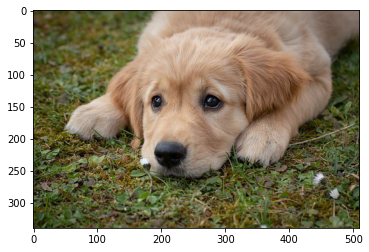

torch.Size([1, 3, 224, 224])

In [9]:
image_file_path = './dog.jpg'
img = Image.open(image_file_path)
mean = (0.485, 0.456, 0.406)
resize = 256
centercrop = 224
std = (0.229, 0.224, 0.225)
plt.imshow(img)
plt.show()

transform = BaseTransfom(resize,centercrop,mean,std)
img_transformed = transform(img)
img_transformed =  img_transformed.unsqueeze_(0)
img_transformed.shape

In [10]:
class_dict = json.load(open('./imagenet-simple-labels.json','r'))
print(len(class_dict))
predictor = Predictor(class_index=class_dict)
out = model(img_transformed)
print(img_transformed.shape)
print(out.shape)
result = predictor.predict_max(out)
print(result)

1000


C:\Users\namlk\miniconda3\envs\d2l\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
bucket


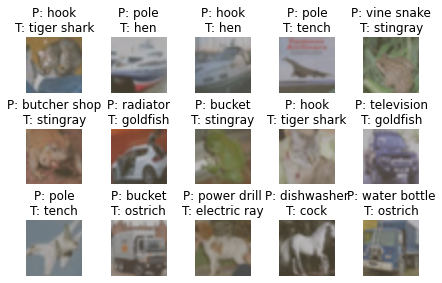

In [11]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [12]:
#class_dict['5'][1]